# Semantic Segmentation with Residual Attention U-net
In this notebook we will use the U-net architecture to predict which pixels in images of hippocampus sections belong to mitochondria. This type of problem set is termed semantic segmentation and the U-net (as introduced by Ronnenberger et al. (www.arxiv.org/abs/1505.04597)) is a useful convolutional neural network architecture to approach the problem of semantic segmentation. The U-net architecture is extended to include attention gates as described by Oktay et al. (https://arxiv.org/pdf/1804.03999.pdf). Additionally, residual units are incorporated similar to work by Zhang et al. (https://arxiv.org/pdf/1711.10684.pdf). The image data used in this notebook can be download from following website: www.epfl.ch/labs/cvlab/data/data-em/. We will first load the image data:

In [1]:
import random 
import warnings
import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import callbacks
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import Concatenate, Add, Activation, Multiply

tf.random.set_seed(2)
random.seed(2)

# Load image data and normalize
file_path_train = ".//training.tif"
file_path_train_mask = ".//training_groundtruth.tif"
file_path_test = ".//testing.tif"
file_path_test_mask = ".//testing_groundtruth.tif"

train = io.imread(file_path_train)
train_mask = io.imread(file_path_train_mask)
test = io.imread(file_path_test)
test_mask = io.imread(file_path_test_mask)

train = np.expand_dims(train / 255, 3)
train_mask = np.expand_dims(train_mask / 255, 3)
test = np.expand_dims(test / 255, 3)
test_mask = np.expand_dims(test_mask / 255, 3)

Let's quickly visualize one image and verify that the corresponding mask belongs to the same image:

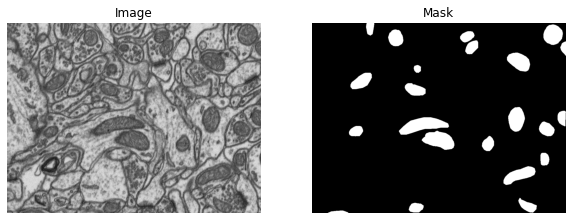

In [2]:
fig, ax = plt.subplots(1,2, figsize=(10, 8))
ax[0].imshow(train[0], cmap="gray")
ax[0].set_title("Image")
ax[1].imshow(train_mask[0], cmap="gray")
ax[1].set_title("Mask")
[axi.set_axis_off() for axi in ax.ravel()]
plt.show()

The training data only contains 165 images. In addition to the small number of training images, these images represent consecutive slices taken from the hippocampus region of the brain. Therefore, some of the images are relatively similiar. To avoid overfitting, it is consequently advisable to augment the training images. We will do so by rotating, flipping, stretching, and zooming in. For our needs, the augmentation procedure has to be exactly the same for each image/mask pair. We will use the albumentations package (www.albumentations.ai) for this as it offers useful functionality for this scenario. We create 330 augmented training images by the code cell shown below:

In [3]:
transform = A.Compose([A.Rotate(30, p=0.7),
                       A.HorizontalFlip(p=0.7),
                       A.VerticalFlip(p=0.7),
                       A.RandomCrop(width=int(train.shape[2] * random.uniform(0.9, 1)), 
                                    height=int(train.shape[1] * random.uniform(0.9, 1))),
                       A.Resize(train.shape[1], train.shape[2])])

repetitions = 1 # 1 means every training image is augmented once
train_augmented = np.zeros((train.shape[0] * (repetitions + 1), train.shape[1], train.shape[2], train.shape[3]))
train_augmented[0:train.shape[0]] = train
train_mask_augmented = np.zeros((train_mask.shape[0] * (repetitions + 1), 
                                 train_mask.shape[1], 
                                 train_mask.shape[2], 
                                 train_mask.shape[3]))
train_mask_augmented[0:train_mask.shape[0]] = train_mask

indices = list(zip(range(train.shape[0], train_augmented.shape[0]), 
                   [k for k in range(0, train.shape[0]) for _ in range(repetitions)]))
for i in indices:
    transformed = transform(image=train[i[1]], mask=train_mask[i[1]])
    train_augmented[i[0]] = transformed["image"]
    train_mask_augmented[i[0]] = transformed["mask"]

Let's quickly visualize that augmentation was succesful and that the masks fit to the augmented images:

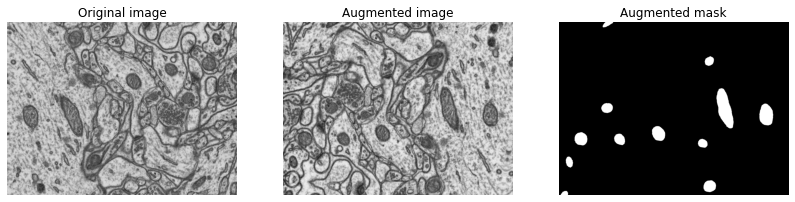

In [4]:
fig, ax = plt.subplots(1,3, figsize=(14, 8))
ax[0].imshow(train[-2], cmap="gray")
ax[0].set_title("Original image")
ax[1].imshow(train_augmented[-2], cmap="gray")
ax[1].set_title("Augmented image")
ax[2].imshow(train_mask_augmented[-2], cmap="gray")
ax[2].set_title("Augmented mask")
[axi.set_axis_off() for axi in ax.ravel()]
plt.show()

Training segmentation tasks on large images can be very resource intensive. Therefore, the class PatchPredictReassemble implements functionality that allows for creation of smaller patches from larger images. It also implements functionality that allows prediction on these patches (if given a previously trained model) and then reassembles the predicted mask to the image shape of the original input image. The patching in this class has two modi. In modus="train" non-overlapping patches are created. In modus="train" overlapping patches are created and then reassembled in a way that reduces predictions originating from near the patch boundaries. The two modi are illustrated below:

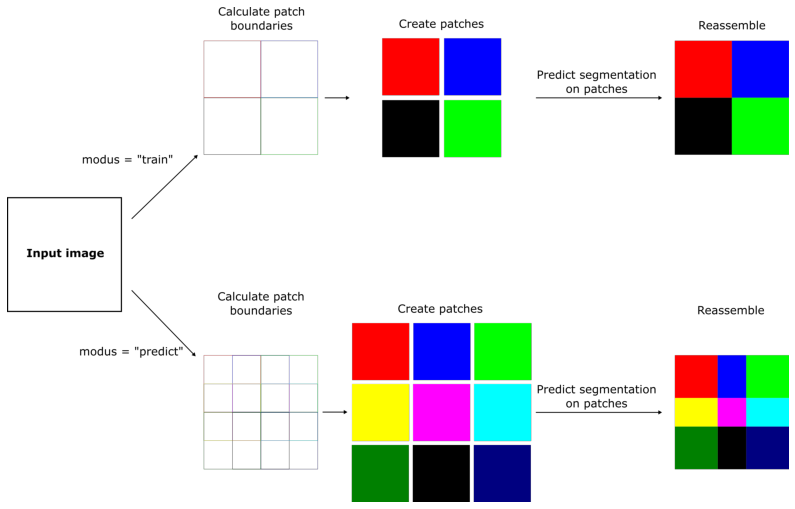

In [5]:
scheme = io.imread(".//patchpredictreassemble.png")
fig, ax = plt.subplots(figsize=(14, 10))
ax.imshow(scheme, cmap="hsv")
ax.set_axis_off()
plt.show()

In [6]:
class PatchPredictReassemble():
    """
    This class is concerned with slicing a larger image into smaller patches, predicting if pixels in those patches belong
    to the target class, and subsequently reassembling those predicted patch masks to masks that fit the original input 
    image shape.
        
    Overview of Methods
    -------
    create_image_patches
    predict_on_patches
    reassemble
    """
    
    def __init__(self, images):
        """
        Parameters
        ----------
        images: numpy.array
            Input image data with following shape: (number of images, image height in pixel, image width in pixel, number of 
            channels).
        """
        self.images = images
        self.no_of_images = self.images.shape[0]
        self.y_image_length = self.images.shape[1]
        self.x_image_length = self.images.shape[2]

        
    def create_image_patches(self, patch_size, modus):
        """
        Creates smaller patches from larger images. The train modus create non-overlapping patches. The predict modus creates
        overlapping patches
        
        Parameters
        ----------
        patch_size: tuple
            Size of the patches that are to be returned. Format: (image height in pixel, image width in pixel).
        modus: string
            Either "train" or "predict". See above.
        
        Returns
        -------
        patched_images: numpy.array
            Patches created from the images.
        """
        
        if modus == "train":
            self.slide_factor = 1
        elif modus == "predict":
            self.slide_factor = 0.5
        
        self.y_patch_length = patch_size[0]
        self.x_patch_length = patch_size[1]
        self.y_slide_increment = self.y_patch_length * self.slide_factor
        self.x_slide_increment = self.x_patch_length * self.slide_factor
        
        self.no_of_patches_along_y = ((self.y_image_length - self.y_patch_length) / self.y_slide_increment) + 1
        self.no_of_patches_along_x = ((self.x_image_length - self.x_patch_length) / self.x_slide_increment) + 1
        
        check_patch_size = [i.is_integer() for i in [self.no_of_patches_along_x, self.no_of_patches_along_y]]
        if all(check_patch_size):
            self.no_of_patches_along_x = int(self.no_of_patches_along_x)
            self.no_of_patches_along_y = int(self.no_of_patches_along_y)
            self.y_slide_increment = int(self.y_slide_increment)
            self.x_slide_increment = int(self.x_slide_increment)
        else:
            raise ValueError("""Please use a combination of patch size & slide factor that allows patching of the image 
                             without remainder.""")

        self.no_of_patched_images = self.no_of_images * self.no_of_patches_along_x * self.no_of_patches_along_y
        self.patched_images = np.zeros((self.no_of_patched_images, self.y_patch_length, self.x_patch_length, 1))
        
        count = 0
        for i in range(self.images.shape[0]):  
            for j in range(self.no_of_patches_along_x):
                x_lower_patch_idx = j * self.x_slide_increment
                x_upper_patch_idx = x_lower_patch_idx + self.x_patch_length

                for k in range(self.no_of_patches_along_y):
                    y_lower_patch_idx = k * self.y_slide_increment
                    y_upper_patch_idx = y_lower_patch_idx + self.y_patch_length
                    self.patched_images[count] = self.images[i, 
                                                             y_lower_patch_idx:y_upper_patch_idx,
                                                             x_lower_patch_idx:x_upper_patch_idx, 
                                                             :]
                    count += 1
        return self.patched_images
        
        
    def predict_on_patches(self, model, cutoff=0.5):
        """
        Predicts if a pixel in a given patch belong to the target class and returns the corresponding predicted mask.
        
        Parameters
        ----------
        model: 
            A model that features a predict method that if feed with the patches stored in the "patched_images" attribute
            returns probabilities for each pixel that indicate if that pixel belongs to the target class.
        
        cutoff: float
            Predicted probabilities larger than the cutoff value are converted to 1, meaning the pixel is assigned to the 
            target class.
            Predicted probabilities lower than the cutoff value are converted to 0, meaning the pixel is not assigned to the
            target class.
        """
        
        self.model = model
        self.predictions = self.model.predict(self.patched_images)
        self.predictions = np.where(self.predictions > cutoff, 1, 0)    
        

    def reassemble(self):
        """
        Reassembles the predicted masks from the predicted patches (="predictions" attribute) so that they fit the shape 
        of the original input image data (="images" attribute).
        
        Returns
        -------
        reassembled_predictions: numpy.array
            Predicted masks for each of the original input images.
        """
        self.reassembled_predictions = np.zeros((self.no_of_images, self.y_image_length, self.x_image_length, 1))

        count = 0
        for i in range(self.no_of_images):
            for j in range(self.no_of_patches_along_x):
                reassembled_x_lower_idx = int(j * self.x_slide_increment + (1 - self.slide_factor) * self.x_slide_increment)
                reassembled_x_upper_idx = reassembled_x_lower_idx + self.x_slide_increment
                if j == 0:
                    reassembled_x_lower_idx = 0
                elif j == (self.no_of_patches_along_x - 1):
                    reassembled_x_upper_idx = self.x_image_length

                for k in range(self.no_of_patches_along_y):
                    reassembled_y_lower_idx = int(k * self.y_slide_increment + (1 - self.slide_factor) * 
                                                  self.y_slide_increment)
                    reassembled_y_upper_idx = reassembled_y_lower_idx + self.y_slide_increment
                    if k == 0:
                        reassembled_y_lower_idx = 0
                    elif k == (self.no_of_patches_along_y - 1):
                        reassembled_y_upper_idx = self.y_image_length

                    patch_y_lower_idx = int(self.y_patch_length * 0.5 - 0.5 * self.y_slide_increment)
                    patch_y_upper_idx = int(self.y_patch_length * 0.5 + 0.5 * self.y_slide_increment)
                    if k == 0:
                        patch_y_lower_idx = 0
                    elif k == (self.no_of_patches_along_y - 1):
                        patch_y_upper_idx = self.y_patch_length
                    
                    patch_x_lower_idx = int(self.x_patch_length * 0.5 - 0.5 * self.x_slide_increment)
                    patch_x_upper_idx = int(self.x_patch_length * 0.5 + 0.5 * self.x_slide_increment)
                    if j == 0:
                        patch_x_lower_idx = 0
                    elif j == (self.no_of_patches_along_x - 1):
                        patch_x_upper_idx = self.x_patch_length
                    
                    self.reassembled_predictions[
                        i, reassembled_y_lower_idx:reassembled_y_upper_idx, 
                        reassembled_x_lower_idx:reassembled_x_upper_idx] = \
                    self.predictions[
                        count, patch_y_lower_idx:patch_y_upper_idx, 
                        patch_x_lower_idx:patch_x_upper_idx]
                    count += 1
        return self.reassembled_predictions

The original images have a (768, 1024) px shape. We will create (256 x 256) px patches from the image data:

In [7]:
patch_size = (256, 256)

train_patches = PatchPredictReassemble(train_augmented).create_image_patches(patch_size, modus="train")
train_mask_patches = PatchPredictReassemble(train_mask_augmented).create_image_patches(patch_size, modus="train")
test_patches = PatchPredictReassemble(test).create_image_patches(patch_size, modus="train")
test_mask_patches = PatchPredictReassemble(test_mask).create_image_patches(patch_size, modus="train")

Let's visualize that creation of patches was succesful for both images and corresponding masks:

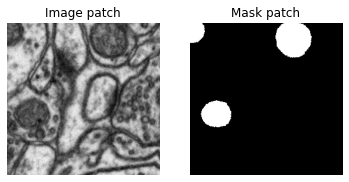

In [8]:
fig, ax = plt.subplots(1,2, figsize=(6, 4))
ax[0].imshow(train_patches[-2], cmap="gray")
ax[0].set_title("Image patch")
ax[1].imshow(train_mask_patches[-2], cmap="gray")
ax[1].set_title("Mask patch")
[axi.set_axis_off() for axi in ax.ravel()]
plt.show()

Now, we will construct our attention U-net architecture:

In [9]:
def attention_res_u_net(input_shape, seed):
    inputs = Input(shape=input_shape)
    initializer = tf.keras.initializers.HeNormal(seed=seed)
    
    
    def residual_conv_block(x, filters, pooling):
        if pooling:
            x = MaxPooling2D((2, 2))(x)
        x = BatchNormalization()(x)  
        
        x1 = Activation("relu")(x)
        x1 = Conv2D(filters, (3, 3), strides=(1, 1), padding="same", kernel_initializer=initializer)(x)
        x1 = BatchNormalization()(x1)
        x1 = Activation("relu")(x1)
        x1 = Conv2D(filters, (3, 3), strides=(1, 1), padding="same", kernel_initializer=initializer)(x1)
        
        x2 = Activation("relu")(x)
        x2 = Conv2D(filters, (1, 1), strides=(1, 1), padding="same", kernel_initializer=initializer)(x2)
        
        x3 = Add()([x1, x2])
        return x3
    
    
    def attention_gate(g, x):
        """
        g: gating signal
        x: skip connection
        """
        no_of_sigmoid1_filters = x.shape[3]
        sigmoid1 = Activation("relu")(
            Add()([Conv2D(no_of_sigmoid1_filters, (1, 1), strides=(2, 2), padding="same", 
                          kernel_initializer=initializer)(x),
                   Conv2D(no_of_sigmoid1_filters, (1, 1), strides=(1, 1), padding="same", 
                          kernel_initializer=initializer)(g)
                  ])
        )   
        sigmoid1 = BatchNormalization()(sigmoid1)
        sigmoid2 = Conv2D(1, (1, 1), activation="sigmoid", padding="same", kernel_initializer=initializer)(sigmoid1)
        sigmoid2 = BatchNormalization()(sigmoid2)
        alpha = UpSampling2D(interpolation="bilinear")(sigmoid2)
        x_hat = Multiply()([x, alpha])
        x_hat = BatchNormalization()(x_hat)
        return x_hat
    
    
    def expansion_block(g, x, filters):
        e_b = UpSampling2D(interpolation="bilinear")(g)
        e_b = BatchNormalization()(e_b)
        a = attention_gate(g, x)
        e_a = residual_conv_block(Concatenate()([a, e_b]), filters=filters, pooling=False)
        return e_a
        
    
    # Contraction
    c1 = residual_conv_block(x=inputs, filters=16, pooling=False)
    c2 = residual_conv_block(x=c1, filters=32, pooling=True)
    c3 = residual_conv_block(x=c2, filters=64, pooling=True)
    
    # Bottleneck
    c4 = residual_conv_block(x=c3, filters=128, pooling=True)
    
    # Expansion
    e3 = expansion_block(c4, c3, 64)
    e2 = expansion_block(e3, c2, 32)
    e1 = expansion_block(e2, c1, 16)
    
    # Final
    outputs = Conv2D(1, (3, 3), activation="sigmoid", padding="same", kernel_initializer=initializer)(e1)

    # Get the model
    model = Model(inputs=inputs, outputs=outputs)
    
    tf.keras.utils.plot_model(model, to_file="attention_res_u-net.png", show_shapes=True)
#     model.summary()
    return model


unet2 = attention_res_u_net(input_shape=(256,256,1), seed=42)

Let's train the model and visualize the training progress:

In [10]:
def scheduler(epoch, lr): 
    return lr * 0.92


unet2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="binary_crossentropy")
cb1 = callbacks.EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=10)               
cb2 = callbacks.LearningRateScheduler(scheduler)
cb3 = callbacks.ModelCheckpoint(".\\unet2", monitor="val_loss", save_best_only=True)

# Saving the model produces a CustomMaskWarning. The model can however be saved and loaded later on without problems
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    history = unet2.fit(train_patches, train_mask_patches, 
                        epochs=50, batch_size=32, validation_data=(test_patches, test_mask_patches),
                        shuffle=True, verbose=1, callbacks=[cb1, cb2, cb3])

Epoch 1/50
124/124 [==============================] - 2111s 17s/step - loss: 0.0988 - val_loss: 0.2842
INFO:tensorflow:Assets written to: .\unet2\assets
Epoch 2/50
124/124 [==============================] - 2097s 17s/step - loss: 0.0350 - val_loss: 0.2642
INFO:tensorflow:Assets written to: .\unet2\assets
Epoch 3/50
124/124 [==============================] - 2092s 17s/step - loss: 0.0278 - val_loss: 0.2760
Epoch 4/50
124/124 [==============================] - 2092s 17s/step - loss: 0.0231 - val_loss: 0.0651
INFO:tensorflow:Assets written to: .\unet2\assets
Epoch 5/50
124/124 [==============================] - 2099s 17s/step - loss: 0.0208 - val_loss: 0.0465
INFO:tensorflow:Assets written to: .\unet2\assets
Epoch 6/50
124/124 [==============================] - 2127s 17s/step - loss: 0.0196 - val_loss: 0.0448
INFO:tensorflow:Assets written to: .\unet2\assets
Epoch 7/50
124/124 [==============================] - 2115s 17s/step - loss: 0.0183 - val_loss: 0.0453
Epoch 8/50
124/124 [=========

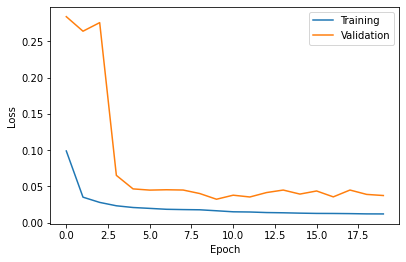

In [11]:
fig, ax = plt.subplots()
ax.plot(history.history["loss"], label="Training")
ax.plot(history.history["val_loss"], label="Validation")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
plt.tight_layout(pad=2.0)
plt.show()

And are now able to load the trained model:

In [12]:
# unet2 = tf.keras.models.load_model(".\\unet2", compile=False)

Now, let's predict on the test set images:

In [13]:
ppr5 = PatchPredictReassemble(test)
ppr5.create_image_patches(patch_size, modus="predict")
ppr5.predict_on_patches(unet2)
test_predictions = ppr5.reassemble()

Let's visualize how good our prediction correspond to the actual mitochondria:

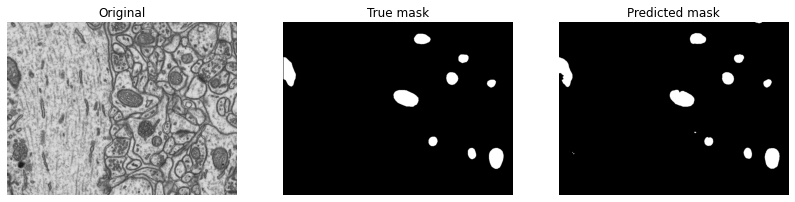

In [14]:
fig, ax = plt.subplots(1,3, figsize=(14, 8))
ax[0].imshow(test[-1], cmap="gray")
ax[0].set_title("Original")
ax[1].imshow(test_mask[-1], cmap="gray")
ax[1].set_title("True mask")
ax[2].imshow(test_predictions[-1], cmap="gray")
ax[2].set_title("Predicted mask")
[axi.set_axis_off() for axi in ax.ravel()]
plt.show()

Finally, we calculate the mean intersection-over-union metric for all the test set predictions:

In [15]:
m = tf.keras.metrics.MeanIoU(num_classes=2)
m.update_state(test_mask, test_predictions)
display(f"The mean intersection-over-union score for the test set is: {m.result().numpy(): .3f}")

'The mean intersection-over-union score for the test set is:  0.888'